In [4]:
# General Libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns


# My Modules
import shap as shap
  
# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [2]:
def eom(u, t, params = {}):
    """
        Duffing Oscillator Equation of Motion

        ddx + delta * dx**2 + alpha * x + beta * x**3 = gamma * cos(omega * t)

        Input
        ----------
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        alpha : float, linear stiffness
        beta  : float, non linearity in the restoring force
        gamma : float, amplitude of the periodic driving force
        delta : float, amount of damping
        omega : float, angular frequency of the periodic driving force

        Returns
        ----------
        [dx,ddx] : Tuple, Time derivatives of 
                    position and velocity at time t

    """
    x, dx = u[0], u[1]
    ddx = (params['gamma'] * np.cos(params['omega'] * t) - 
           (params['delta'] * dx + params['alpha'] * x + params['beta'] * x**3))

    return [dx,ddx]

In [89]:
def generate(num_samples = int(5e1), delay=0, samples=100, end_time=30):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
        parameters = {
                      'alpha': [np.linspace(-1,-1,1)],
                      'beta': [np.linspace(1,1,1)],
                      'gamma': [np.linspace(0.37,0.37,1)],
                      'delta': [np.linspace(0.3,0.3,1)],
                      'omega': [np.linspace(1.2,1.2,1)]
                     }
        #Define bounds of the sampling
        x_min = 0.9#-2
        x_max = 1.1#2
        v_min = -0.1#-2
        v_max = 0.1#2
        #Initialise the output arrays
        parameter_length = 1
        labels = ['xt','vt']
        for key in parameters:
            parameter_length  *= len(parameters[key][0])
        complete_feature_vec = ['x0','v0','t','rand']
        for k in parameters:
            complete_feature_vec.append(k)  
        X = np.empty((num_samples*parameter_length*samples, (len(complete_feature_vec))))
        y = np.empty((num_samples*parameter_length*samples, len(labels)))
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = [int(100/samples*i) for i in range(samples)]
        #Generate num_samples samples
        ticker = 0
        for alpha in parameters['alpha'][0]:
            for beta in parameters['beta'][0]:
                for gamma in parameters['gamma'][0]:
                    for delta in parameters['delta'][0]:
                        for omega in parameters['omega'][0]:
                            current_params = {'alpha' : alpha,'beta' : beta, 'delta' : delta, 
                                                       'gamma' :gamma, 'omega' : omega}
                            
                             
                            for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
                                #Generate random starting positions
                                x0 = (x_max - x_min) * np.random.random_sample() + x_min
                                v0 = 0#(v_max - v_min) * np.random.random_sample() + v_min 
                                #Generate a trajectory
                                func = lambda u,t: eom(u, t, params = current_params)
                                trajectory = odeint(func, [x0,v0], t_range)
                                for j, t_ind in enumerate(t_vals):
                                    X[j+i*samples+ticker*num_samples*samples,:] = [x0, v0, t_range[t_ind], np.random.sample(), 
                                                                            alpha, beta, gamma, delta, omega]
                                    y[j+i*samples+ticker*num_samples*samples,:] = trajectory[t_ind,:]
                            ticker +=1        
                                    
                                    
        
        
        X_df = pd.DataFrame(X, columns = complete_feature_vec)
        y_df = pd.DataFrame(y, columns = labels)
        return X_df, y_df

In [90]:
X,y = generate(num_samples = int(1e4))

Generating Data…: 100%|█████████████| 10000/10000 [00:48<00:00, 205.98it/s]


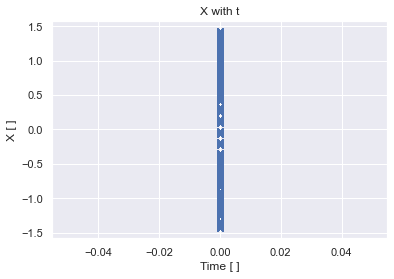

In [92]:
plt.plot(X['v0'], y['xt'], 'x')

plt.title("X with t")
plt.xlabel('Time [ ]')
plt.ylabel('X [ ]')

plt.savefig("Images/parameter_config_fixed_start_v0_0_beta1,alphaminus1_v_xt.png", dpi=400)